# Dashboard final — visualisations avancées

Ce notebook lit les artefacts produits par l'analyse (dans `outputs/analysis_results`) et génère :

- UMAP interactif (Plotly)
- Barplot de coverage par topic
- Heatmap lexical vs sémantique (moyennes par topic)
- Graphique des similarités par topic (distribution)
- Wordcloud des entités Forbes (si `forbes_entities.csv` présent)
- Tableaux filtrables (par source, topic, sentiment, framing)
- Section **Interprétations** automatique (résumé synthétique)

Exécute chaque cellule dans l'ordre. Le notebook **n'écrase** rien — il ne modifie que les fichiers de sortie si tu le souhaites explicitement.


In [3]:

# 1. Imports & chemins
import os, json
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display, HTML
sns.set(style='whitegrid')

RES = os.path.join('./outputs/analysis_results')
ARTIFACTS = {}
if os.path.exists(RES):
    ARTIFACTS = {fn: os.path.join(RES,fn) for fn in os.listdir(RES)}
print('Results folder:', RES)
print('Found artifacts:', sorted(list(ARTIFACTS.keys())))


Results folder: ./outputs/analysis_results
Found artifacts: ['all_with_sentiment.csv', 'aspect_sentiment_forbes.csv', 'coverage_combined_forbes.csv', 'embeddings.npy', 'forbes_entities.csv', 'framing_forbes.csv', 'lexical_coverage_forbes.csv', 'oms_to_forbes_pairs.csv', 'oms_topics.json', 'semantic_similarity_forbes.csv', 'stat_tests.txt']


## 2. Charger les fichiers produits
Le notebook cherchera les fichiers suivants (certains sont optionnels) :
- `umap_coords_with_meta.csv`
- `coverage_combined_forbes.csv`
- `semantic_similarity_forbes.csv`
- `lexical_coverage_forbes.csv`
- `document_sentiment.csv`
- `aspect_sentiment_forbes.csv`
- `framing_forbes.csv`
- `forbes_entities.csv`
- `oms_to_forbes_pairs.csv`

Si un fichier manque, la cellule indique son absence et la visualisation concernée est ignorée.


In [5]:

# load artifacts if present
def load_if(fn):
    p = os.path.join(RES, fn)
    return pd.read_csv(p) if os.path.exists(p) else None

coords = load_if('umap_coords_with_meta.csv')
cov = load_if('coverage_combined_forbes.csv')
sim = load_if('semantic_similarity_forbes.csv')
lex = load_if('lexical_coverage_forbes.csv')
sent = load_if('document_sentiment.csv')
aspect = load_if('aspect_sentiment_forbes.csv')
fr = load_if('framing_forbes.csv')
ents = load_if('forbes_entities.csv')
pairs = load_if('oms_to_forbes_pairs.csv')
art = None
if os.path.exists(os.path.join(OUT_DIR,'all_articles_processed_with_preview.csv')):
    art = pd.read_csv(os.path.join(OUT_DIR,'all_articles_processed_with_preview.csv'))
elif os.path.exists(os.path.join('../data/all_data_processed.csv')):
    art = pd.read_csv(os.path.join('../data/all_data_processed.csv'))

print('Loaded: coords', coords is not None, 'cov', cov is not None, 'sim', sim is not None, 'lex', lex is not None)
print('Loaded: sent', sent is not None, 'aspect', aspect is not None, 'fr', fr is not None, 'ents', ents is not None, 'pairs', pairs is not None)
print('Articles DF loaded:', art is not None if art is not None else False)


Loaded: coords False cov True sim True lex True
Loaded: sent False aspect True fr True ents True pairs True
Articles DF loaded: True


## 3. UMAP interactif (Plotly)
Affiche la projection UMAP si `umap_coords_with_meta.csv` est présent. Utilise `preview` ou `title` en hover.


In [6]:

if coords is None:
    print('UMAP coordinates not found. Skipping UMAP plot.')
else:
    hover_cols = []
    for c in ['preview','title','source','date']:
        if c in coords.columns:
            hover_cols.append(c)
    fig = px.scatter(coords, x='umap_x', y='umap_y', color='source' if 'source' in coords.columns else None,
                     hover_data=hover_cols, height=700, title='UMAP projection (sources colored)')
    fig.update_traces(marker=dict(size=6, opacity=0.8))
    fig.show()


UMAP coordinates not found. Skipping UMAP plot.


## 4. Coverage bar (Forbes coverage per OMS topic)
Visualisation simple du nombre d'articles Forbes couvrant chaque topic OMS (fichier `coverage_combined_forbes.csv`).

In [7]:

if cov is None:
    print('Coverage file missing — skipping coverage bar.')
else:
    topic_cols = [c for c in cov.columns if c.startswith('covered_topic_')]
    cover_counts = cov[topic_cols].sum().reset_index()
    cover_counts.columns = ['metric','count']
    cover_counts['topic'] = cover_counts['metric'].str.replace('covered_topic_','').astype(int)
    fig = px.bar(cover_counts, x='topic', y='count', title='Forbes coverage per OMS topic')
    fig.update_layout(xaxis_title='Topic ID', yaxis_title='Count of Forbes articles')
    fig.show()


## 5. Heatmap lexical vs sémantique
Calcule la moyenne lexicale (TF-IDF overlap) et moyenne sémantique (cosine sim) par topic et affiche une heatmap combinée.

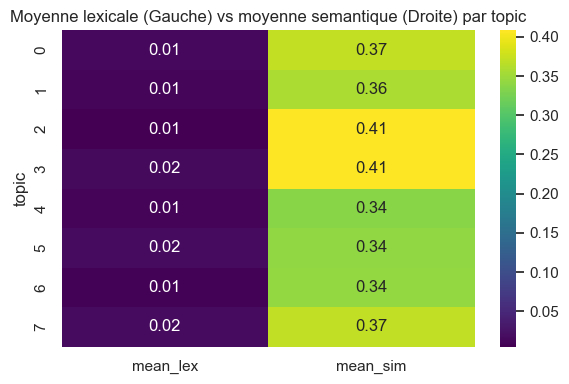

In [9]:

import matplotlib.pyplot as plt
import numpy as np

if lex is None and sim is None:
    print('Lexical and semantic files missing — skipping heatmap.')
else:
    # prepare dataframe with mean lex and mean sim per topic
    rows = []
    # detect topic ids from column names
    topic_ids = set()
    if lex is not None:
        topic_ids |= {int(c.replace('lex_topic_','')) for c in lex.columns if c.startswith('lex_topic_')}
    if sim is not None:
        topic_ids |= {int(c.replace('sim_topic_','')) for c in sim.columns if c.startswith('sim_topic_')}
    topic_ids = sorted(topic_ids)
    for t in topic_ids:
        mean_lex = lex[f'lex_topic_{t}'].mean() if (lex is not None and f'lex_topic_{t}' in lex.columns) else np.nan
        mean_sim = sim[f'sim_topic_{t}'].mean() if (sim is not None and f'sim_topic_{t}' in sim.columns) else np.nan
        rows.append({'topic':t,'mean_lex':mean_lex,'mean_sim':mean_sim})
    df_metrics = pd.DataFrame(rows).set_index('topic')
    # heatmap
    plt.figure(figsize=(6, max(4, len(df_metrics)*0.5)))
    sns.heatmap(df_metrics.fillna(0), annot=True, fmt='.2f', cmap='viridis')
    plt.title('Moyenne lexicale (Gauche) vs moyenne semantique (Droite) par topic')
    plt.tight_layout()
    plt.show()


## 6. Graphique des similarités par topic (distribution)
Pour chaque topic, afficher la distribution des similarités (violin/box) à partir de `semantic_similarity_forbes.csv`. Permet d'identifier les topics où Forbes est plus proche sémantiquement.


In [10]:

if sim is None:
    print('Semantic similarity file missing — skipping similarity distributions.')
else:
    # reshape sim dataframe to long format
    sim_cols = [c for c in sim.columns if c.startswith('sim_topic_')]
    sim_long = sim.melt(id_vars=['global_index'], value_vars=sim_cols, var_name='topic', value_name='sim')
    sim_long['topic'] = sim_long['topic'].str.replace('sim_topic_','').astype(int)
    fig = px.box(sim_long, x='topic', y='sim', points='outliers', title='Semantic similarity distribution by topic (Forbes articles)')
    fig.update_layout(xaxis_title='Topic ID', yaxis_title='Cosine similarity to topic centroid')
    fig.show()


## 7. Wordcloud des entités Forbes
Si `forbes_entities.csv` est disponible, génère un wordcloud par label (ORG, GPE, PER...). Sinon affiche un top-entities table.


,entity,label,count
86,Afrique,LOC,123
303,Bénin,LOC,81
1638,l'Afrique,LOC,56
464,Côte d'Ivoire,LOC,51
689,Gabon,LOC,45
607,FMI,ORG,31
1702,État,LOC,25
1021,Maroc,LOC,24
313,CFA,MISC,24
352,Celtiis,PER,22


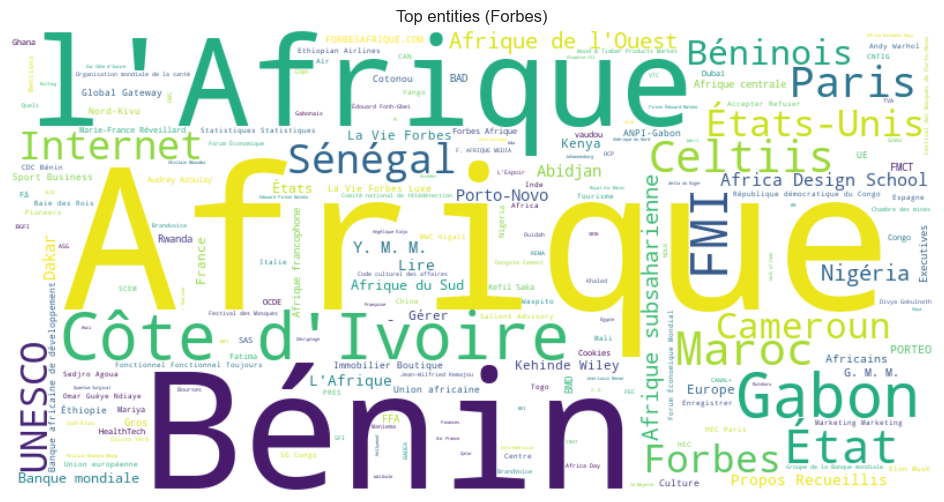

In [11]:

if ents is None:
    print('Entities file missing — skipping wordcloud.')
else:
    try:
        from wordcloud import WordCloud
        have_wordcloud = True
    except Exception:
        have_wordcloud = False
        print('WordCloud lib not installed — will show top entities table instead.')

    # prepare counts per entity text
    ent_counts = ents.groupby(['entity','label']).size().reset_index(name='count').sort_values('count', ascending=False)
    display(ent_counts.head(30))

    if have_wordcloud:
        # create a combined wordcloud (weights by count)
        freq = {row['entity']: int(row['count']) for _, row in ent_counts.head(500).iterrows()}
        wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq)
        plt.figure(figsize=(12,6))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title('Top entities (Forbes)')
        plt.show()


## 8. Tableaux filtrables (interactive) — par source, topic, sentiment, framing
Utilise Plotly Dashboards-like filtering via dropdowns and shows a table of articles with selected filters.


In [ ]:

# Interactive filtering using plotly + pandas display
from ipywidgets import widgets, interact, interactive, HBox, VBox

# base dataframe to show
if art is None:
    print('Articles CSV not found — cannot show interactive table. Expected all_articles_processed.csv or _with_preview variant in outputs/.')
else:
    df_articles = art.copy()
    # ensure index alignment if global_index used elsewhere
    if 'preview' not in df_articles.columns:
        df_articles['preview'] = df_articles.get('titre','').astype(str)
    # add sentiment and framing if available
    if sent is not None:
        sd = sent[['global_index','label']].rename(columns={'global_index':'index','label':'sent_label'})
        df_articles = df_articles.reset_index().rename(columns={'index':'index'}).merge(sd, left_on='index', right_on='index', how='left').set_index('index')
    if fr is not None:
        frs = fr[['global_index','framing']].rename(columns={'global_index':'index'})
        df_articles = df_articles.reset_index().merge(frs, left_on='index', right_on='index', how='left').set_index('index')

    # widget options
    src_opts = ['All'] + sorted(df_articles['source'].dropna().unique().tolist())
    def show_table(source='All', keyword='', sentiment='All', framing_choice='All', max_rows=50):
        d = df_articles.copy()
        if source != 'All':
            d = d[d['source']==source]
        if keyword:
            d = d[d['preview'].str.contains(keyword, case=False, na=False) | d['title'].str.contains(keyword, case=False, na=False)]
        if sentiment != 'All' and 'sent_label' in d.columns:
            d = d[d['sent_label'].str.contains(sentiment, case=False, na=False)]
        if framing_choice != 'All' and 'framing' in d.columns:
            d = d[d['framing']==framing_choice]
        display(d[['source','title','preview']].head(max_rows))

    src_widget = widgets.Dropdown(options=src_opts, description='Source:')
    key_widget = widgets.Text(description='Keyword:')
    sent_widget = widgets.Dropdown(options=['All'] + (sorted(sent['label'].unique().tolist()) if sent is not None else []), description='Sent:')
    framing_widget = widgets.Dropdown(options=['All'] + (sorted(fr['framing'].unique().tolist()) if fr is not None else []), description='Framing:')
    rows_widget = widgets.IntSlider(value=20, min=5, max=200, step=5, description='Rows:')

    ui = VBox([HBox([src_widget, key_widget, sent_widget, framing_widget, rows_widget])])
    out = widgets.interactive_output(show_table, {'source':src_widget, 'keyword':key_widget, 'sentiment':sent_widget, 'framing_choice':framing_widget, 'max_rows':rows_widget})
    display(ui, out)


## 9. Section Interprétations (générée automatiquement)
Le notebook produit un texte synthétique indiquant :
- Top topics couverts par Forbes
- Proportion sentiment positive/négative
- Framing dominant
- Top entités citées

Ceci est une **traduction automatique** des métriques — vérifie manuellement pour la présentation.


In [ ]:

# Auto-interpretation (best-effort summaries)
interpretations = []
# top covered topics
if cov is not None:
    topic_cols = [c for c in cov.columns if c.startswith('covered_topic_')]
    cover_counts = cov[topic_cols].sum().rename(lambda x: int(x.replace('covered_topic_','')))
    top_topics = cover_counts.sort_values(ascending=False).head(3)
    interpretations.append(f"Top topics covered by Forbes (by article count): {', '.join([f'Topic {t} ({int(c)})' for t,c in top_topics.items()])}.")
else:
    interpretations.append('No coverage data available to determine top topics.')

# sentiment summary
if sent is not None:
    s = sent['label'].value_counts()
    total = s.sum()
    pos = s.filter(like='POS').sum() if any(['POS' in str(x).upper() for x in s.index]) else s.get('POS',0) if 'POS' in s.index else 0
    neg = s.filter(like='NEG').sum() if any(['NEG' in str(x).upper() for x in s.index]) else s.get('NEG',0) if 'NEG' in s.index else 0
    interpretations.append(f"Document-level sentiment: POS ~{int(pos)}/{int(total)}, NEG ~{int(neg)}/{int(total)} (raw counts).")
else:
    interpretations.append('No document-level sentiment file available.')

# framing
if fr is not None and not fr.empty:
    framing_counts = fr['framing'].value_counts()
    dominant = framing_counts.idxmax()
    interpretations.append(f"Dominant framing among covered Forbes articles: {dominant} (counts: {framing_counts.to_dict()}).")
else:
    interpretations.append('No framing file available.')

# top entities
if ents is not None:
    top_ent = ents.groupby('entity').size().sort_values(ascending=False).head(10)
    interpretations.append('Top entities mentioned in Forbes: ' + ', '.join([f"{e} ({c})" for e,c in top_ent.items()]) + '.')
else:
    interpretations.append('No entities file available.')

# print nicely
display(HTML('<h3>Interprétations automatiques (brouillon)</h3>'))
for p in interpretations:
    display(HTML(f"<p>{p}</p>"))


## 10. Export (optionnel)
Si tu veux, ce notebook peut sauvegarder un petit HTML `index_final.html` dans le dossier `analysis_results` réunissant les plots en images et le texte d'interprétation. Décommente et exécute la cellule ci-dessous pour écrire le fichier.


In [ ]:

# Optional: write a tiny HTML summary (uncomment to enable)
write_html = False
if write_html and os.path.exists(RES):
    html = ['<html><head><meta charset="utf-8"><title>Final Dashboard</title></head><body>']
    html.append('<h1>Final Dashboard — summary</h1>')
    for img in ['umap_by_source.png','coverage_bar_forbes.png','sentiment_by_source.png','framing_pie_forbes.png']:
        p = os.path.join(RES,img)
        if os.path.exists(p):
            html.append(f"<h3>{img}</h3><img src='{img}' width='800'/>")
    # append interpretations
    html.append('<h2>Interpretations</h2>')
    for p in interpretations:
        html.append(f'<p>{p}</p>')
    html.append('</body></html>')
    with open(os.path.join(RES,'index_final.html'),'w',encoding='utf-8') as f:
        f.write('\n'.join(html))
    print('Wrote', os.path.join(RES,'index_final.html'))
else:
    print('HTML export not enabled (set write_html=True to enable).')
